# Plot lidar timestamps for USGS lidar datasets
* Crude first pass at PDAL workflow to look for points near stereo collection dates.

## Downloads and imports

In [5]:
import json
import astropy.time
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

## PDAL pipeline for Washington state lidar datasets only (check CRS for others)

In [2]:
# https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_WA_MtBaker_2015_LAS_2017/ept.json

In [13]:
# !rm "$decimated_fn"
dates_csv_fn = "testdates.csv"
crs = "EPSG:32610" # target
pipeline_fn = "pdal_pipeline_dates_baker.json"
# pipeline_fn = "pdal_pipeline_dates_mesaco.json"
# ept_fn = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_WY_Carbon_2015_LAS_2018/ept.json" # 2015-10-25 - 2016-07-27
# ept_fn = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/WY_YellowstoneNP_2_2020/ept.json"
ept_fn = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_WA_MtBaker_2015_LAS_2017/ept.json"
# ept_fn = "http://usgs-lidar-public.s3.amazonaws.com/USGS_LPC_CO_MesaCo_QL2_2015_LAS_2017/ept.json"
# ept_fn = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_WA_GlacierPeak_2014_LAS_2016/ept.json"
pipeline_dict = {"pipeline":
 [
     {
         "type": "readers.ept",
         "filename": ept_fn,
         "resolution": 1000, # appears to be the coarsest resolution that 
#          "bounds":"([-12052000,-12051000],[4703000.100927155,4704000.623964248])"                 
#          "bounds":"([-12052985.230605898,-11988698.905804213],[4702177.100927155,4736451.623964248])"
     },
    {
        "type": "filters.reprojection",
        "out_srs": crs,
    },
    {
        "type": "writers.text",
        "format": "csv",
        "order": "X,Y,Z,GpsTime",
        "keep_unspecified": "false",
        "filename": dates_csv_fn
    }
 ]
}
with open(pipeline_fn, "w") as of:
    json.dump(pipeline_dict, of)


!pdal pipeline "$pipeline_fn"
!wc -l "$dates_csv_fn"

85903 testdates.csv


In [14]:
def gpstime_to_utc(gpstime):
    """Convert GpsTime from LAZ files to UTC timestamps using AstroPy"""
    return astropy.time.Time(10**9 + float(gpstime), format="gps").datetime

In [15]:
gdf = gpd.read_file(dates_csv_fn, crs=crs)#, dtype={"X":float,"Y":float,"Z":float,"GpsTime":float})#, geometry=gpd.points_from_xy(df.X, df.Y))
gdf = gdf.apply(pd.to_numeric) # floats are getting read in as strings

gdf["UTCTime"] = gdf["GpsTime"].apply(gpstime_to_utc)
gdf.geometry = gpd.points_from_xy(gdf.X, gdf.Y)
gdf["day_of_year"] = gdf["UTCTime"].dt.dayofyear
gdf["datestamp"] = gdf["UTCTime"].dt.strftime("%Y-%m-%d")
gdf["time_since_first"] = gdf["UTCTime"] - gdf["UTCTime"].min() # for plotting
gdf["days_since_first"] = gdf["time_since_first"].dt.days
# gdf.head()

/mnt/1.0_TB_VOLUME/sethv/miniconda3/envs/der/lib/python3.10/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [16]:
gdf.groupby("datestamp")["datestamp"].count()

datestamp
2015-08-26     1959
2015-08-27     4438
2015-09-05     4956
2015-09-09      444
2015-09-10    15735
2015-09-11    13199
2015-09-12    17364
2015-09-13      624
2015-09-14     1198
2015-09-16     6927
2015-09-22      817
2015-09-23    10576
2015-09-24     3813
2015-09-27     3852
Name: datestamp, dtype: int64

## Discoveries from this investigation
* Mesa County whole ept spans 2015-11-02 to 2016-07-17 even with reduced bounds, majority of points 2016-07-13 and 2017-07-14
    * 
* Adams
    * 
* Glacier Peak 2014-2015 could still be useful if we look closer at the areas near the actual peak, which almost fall in a tighter date range
    ```
    2014-08-25     366
    ...
    2014-11-19    1307
    2015-06-06    1171
    ...
    2015-06-24      92
    ```
    update: No
    * Day 249 east half
    * Day 254 west half
    * Day 257 some more points???
    * MOST points within 4000m of summit are 2014-09-06 to 2014-09-14
    * But the WV DEM is 2014-08-03. Sad!
* Wyoming
    * Wind River Range
    * 
* Yellowstone 2020 has some potential? https://s3-us-west-2.amazonaws.com/usgs-lidar-public/WY_YellowstoneNP_2_2020/ept.json

In [17]:
gdf["keep"] = [x % 10 for x in range(len(gdf))]
gdf_small = gdf[gdf["keep"] == 0]
len(gdf_small)

8591

Text(0.5, 1.0, 'Z= elevation for subsampled points')

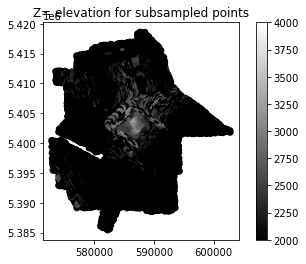

In [21]:
gdf_small.plot(column="Z", cmap="gray", vmin=2000, vmax=4000, legend=True)
plt.title("Z= elevation for subsampled points")

Text(0.5, 1.0, 'Day of Year for points - Baker?')

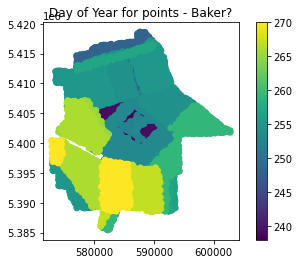

In [23]:
gdf_small.plot(column="day_of_year", legend=True)
plt.title("Day of Year for points - Baker?")

In [24]:
gdf.iloc[gdf["Z"].argmax()]

X                                       587595.171
Y                                      5404260.312
Z                                          4219.29
GpsTime                              125875613.305
geometry            POINT (587595.171 5404260.312)
UTCTime                 2015-09-09 23:13:52.305000
day_of_year                                    252
datestamp                               2015-09-09
time_since_first           14 days 05:36:11.056000
days_since_first                                14
keep                                             7
Name: 11457, dtype: object

In [25]:
from shapely.geometry import Point

In [26]:
peak_point = gdf.iloc[gdf["Z"].argmax()]
peak_point_xy = Point(peak_point["X"], peak_point["Y"])

In [27]:
gdf.distance(peak_point_xy).head()

0    470.499931
1    410.270423
2    637.327158
3    260.842399
4    500.705019
dtype: float64

In [28]:
gdf_near_peak = gdf[gdf.distance(peak_point_xy) < 4000]

In [29]:
len(gdf_near_peak)

7396

Text(0.5, 1.0, 'Day of year for points centered around Glacier Peak')

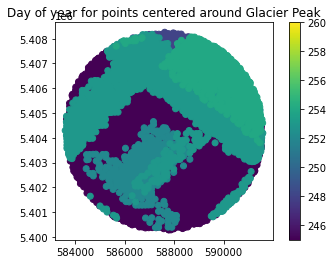

In [30]:
gdf_near_peak.plot(column="day_of_year",legend=True, vmin=245, vmax=260)
plt.title("Day of year for points centered around Glacier Peak")

In [98]:
gdf_near_peak["X"].min(), gdf_near_peak["X"].max()

(639276.0, 641766.5)

In [99]:
gdf_near_peak["Y"].min(), gdf_near_peak["Y"].max()

(5331948.173, 5334442.98)

In [107]:
gdf_near_peak.groupby("datestamp").count()

,X,Y,Z,GpsTime,geometry,UTCTime,day_of_year,time_since_first,days_since_first
datestamp,,,,,,,,,
2014-08-26,3128,3128,3128,3128,3128,3128,3128,3128,3128
2014-08-27,3140,3140,3140,3140,3140,3140,3140,3140,3140
2014-09-06,31388,31388,31388,31388,31388,31388,31388,31388,31388
2014-09-07,13400,13400,13400,13400,13400,13400,13400,13400,13400
2014-09-11,19376,19376,19376,19376,19376,19376,19376,19376,19376
2014-09-14,6784,6784,6784,6784,6784,6784,6784,6784,6784
2014-09-22,842,842,842,842,842,842,842,842,842
2014-10-02,997,997,997,997,997,997,997,997,997
2014-10-03,35,35,35,35,35,35,35,35,35


In [14]:
# Somehow this takes really long??? Why, too many points to overlay?
# fig, ax = plt.subplots(ncols=2, figsize=(10,10))
# gdf_small.plot(column="Z", ax=ax[0], cmap="gray", legend=True)
# gdf_small.plot(ax=ax[1], column="day_of_year", legend=True)

# plt.title(f"{ept_fn} points \n day of the year")
# # plt.tight_layout()